# Exercise 2 – Classification Task

## Telco Customer Churn Classification with 3 Models

# 1. Introdction
- Aim: Predict if a customer will churn (leave) or not churn.
- Will use three models: Logistic Regression, Decision Tree, Random Forest.
- Will show metrics: Accuracy, Precision, Recall, F1, Confusion Matrix, ROC, Precision-Recall.

# 2. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, roc_auc_score, precision_recall_curve,
                             average_precision_score, classification_report)
import warnings
warnings.filterwarnings('ignore')


# 3. Load Data


In [2]:
path = '/kaggle/input/telco-customer-churn-dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(path)
print("Rows, columns:", df.shape)
df.head()

Rows, columns: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# 3. Missing Values

In [3]:
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nUnique values for 'Churn':", df['Churn'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("TotalCharges missing before fill:", df['TotalCharges'].isnull().sum())

mask = df['TotalCharges'].isnull()
df.loc[mask, 'TotalCharges'] = (df.loc[mask, 'MonthlyCharges'] * df.loc[mask, 'tenure'])
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
print("TotalCharges missing after fill:", df['TotalCharges'].isnull().sum())

if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

print("\nAfter cleaning:")
print(df.info())


TotalCharges missing before fill: 11
TotalCharges missing after fill: 0

After cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  

# 4. Data Analysis

## Churn Value Counts

Churn value counts:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64


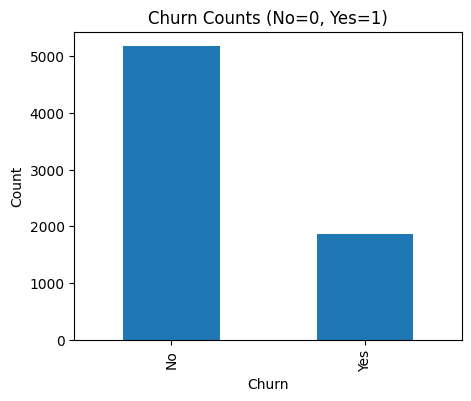

In [5]:
print("Churn value counts:\n", df['Churn'].value_counts())

plt.figure(figsize=(5,4))
df['Churn'].value_counts().plot(kind='bar')
plt.title('Churn Counts (No=0, Yes=1)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

## Tenure Distribution

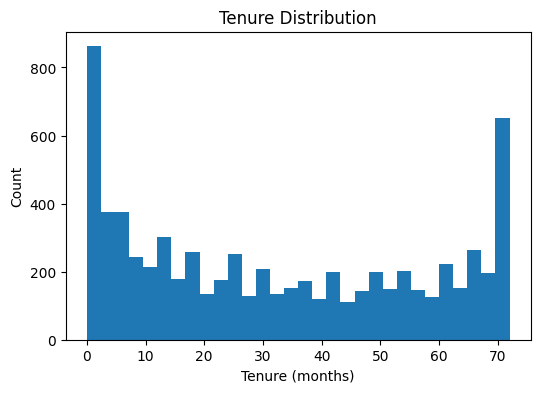

In [6]:
plt.figure(figsize=(6,4))
plt.hist(df['tenure'], bins=30)
plt.title('Tenure Distribution')
plt.xlabel('Tenure (months)')
plt.ylabel('Count')
plt.show()

## Monthly Charges Distribution

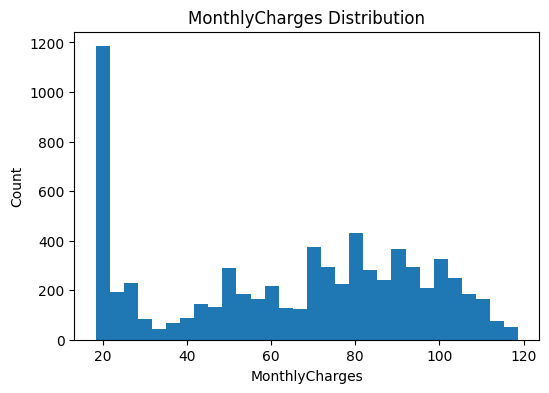

In [7]:
plt.figure(figsize=(6,4))
plt.hist(df['MonthlyCharges'], bins=30)
plt.title('MonthlyCharges Distribution')
plt.xlabel('MonthlyCharges')
plt.ylabel('Count')
plt.show()

# 5. Preprocessing (encoding, scaling, train/test split)

In [8]:
data = df.copy()

data['Churn'] = data['Churn'].map({'Yes':1, 'No':0})

numeric_cols = data.select_dtypes(include=['int64','float64']).columns.tolist()
if 'Churn' in numeric_cols:
    numeric_cols.remove('Churn')
cat_cols = data.select_dtypes(include=['object']).columns.tolist()

print("Numeric cols:", numeric_cols)

Numeric cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [9]:
print("Categorical cols:", cat_cols)

Categorical cols: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [10]:
for col in cat_cols:
    data[col] = data[col].replace({'No internet service':'No', 'No phone service':'No'})

data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
print("Shape after encoding:", data.shape)

Shape after encoding: (7043, 24)


# 6. Feature Targets

In [11]:
X = data.drop('Churn', axis=1)
y = data['Churn']

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train churn distribution:\n", y_train.value_counts(normalize=True))
print("Test churn distribution:\n", y_test.value_counts(normalize=True))

Train shape: (5634, 23) Test shape: (1409, 23)
Train churn distribution:
 Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64
Test churn distribution:
 Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


# 7. Train models: Logistic Regression, Decision Tree, Random Forest


## Create Models

In [12]:
lr = LogisticRegression(max_iter=1000, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

## Train

In [13]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [14]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [15]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Predict

In [16]:
y_pred_lr = lr.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)

In [17]:
y_prob_lr = lr.predict_proba(X_test)[:,1]
y_prob_dt = dt.predict_proba(X_test)[:,1] if hasattr(dt, 'predict_proba') else None
y_prob_rf = rf.predict_proba(X_test)[:,1]

# 8. Evaluation of Matrics


In [18]:
def print_metrics(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Model: {name}")
    print(f" Accuracy: {acc:.4f}")
    print(f" Precision: {prec:.4f}")
    print(f" Recall: {rec:.4f}")
    print(f" F1-score: {f1:.4f}")
    print(classification_report(y_true, y_pred, digits=4))
    print("----E N D-----E N D------E N D------E N D------E N D----")

## All 3 Model Matrics

In [19]:
print_metrics(y_test, y_pred_lr, "Logistic Regression")

Model: Logistic Regression
 Accuracy: 0.8055
 Precision: 0.6582
 Recall: 0.5561
 F1-score: 0.6029
              precision    recall  f1-score   support

           0     0.8481    0.8957    0.8712      1035
           1     0.6582    0.5561    0.6029       374

    accuracy                         0.8055      1409
   macro avg     0.7532    0.7259    0.7371      1409
weighted avg     0.7977    0.8055    0.8000      1409

----E N D-----E N D------E N D------E N D------E N D----


In [20]:
print_metrics(y_test, y_pred_dt, "Decision Tree")

Model: Decision Tree
 Accuracy: 0.7331
 Precision: 0.4972
 Recall: 0.4679
 F1-score: 0.4821
              precision    recall  f1-score   support

           0     0.8117    0.8290    0.8203      1035
           1     0.4972    0.4679    0.4821       374

    accuracy                         0.7331      1409
   macro avg     0.6544    0.6484    0.6512      1409
weighted avg     0.7282    0.7331    0.7305      1409

----E N D-----E N D------E N D------E N D------E N D----


In [21]:
print_metrics(y_test, y_pred_rf, "Random Forest")

Model: Random Forest
 Accuracy: 0.7942
 Precision: 0.6458
 Recall: 0.4973
 F1-score: 0.5619
              precision    recall  f1-score   support

           0     0.8323    0.9014    0.8655      1035
           1     0.6458    0.4973    0.5619       374

    accuracy                         0.7942      1409
   macro avg     0.7391    0.6994    0.7137      1409
weighted avg     0.7828    0.7942    0.7849      1409

----E N D-----E N D------E N D------E N D------E N D----


## Confusion Matrics Visualisation

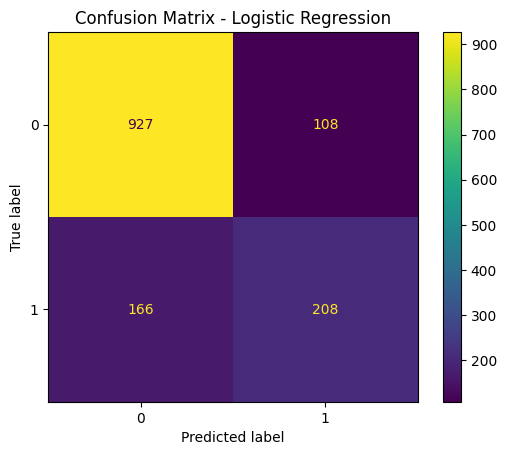

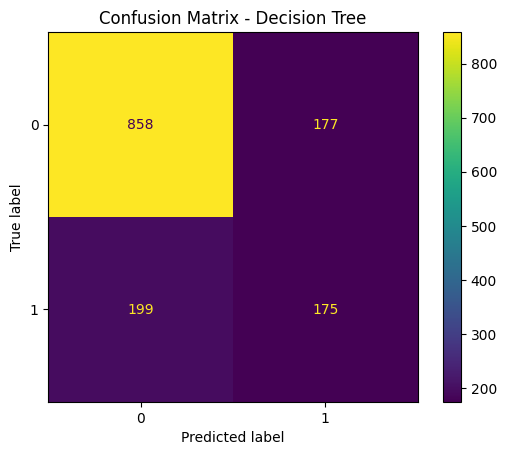

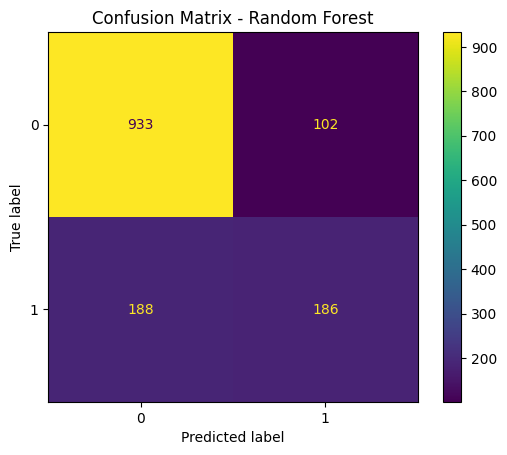

In [22]:
models_preds = [("Logistic Regression", y_pred_lr), 
                ("Decision Tree", y_pred_dt), 
                ("Random Forest", y_pred_rf)]

for name, yp in models_preds:
    cm = confusion_matrix(y_test, yp)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# 9. AUC & ROC Visualisations

Full Form: Receiver Operating Characteristic Curve (ROC) & Area Under the Curve (AUC)

##  Logistic Regression

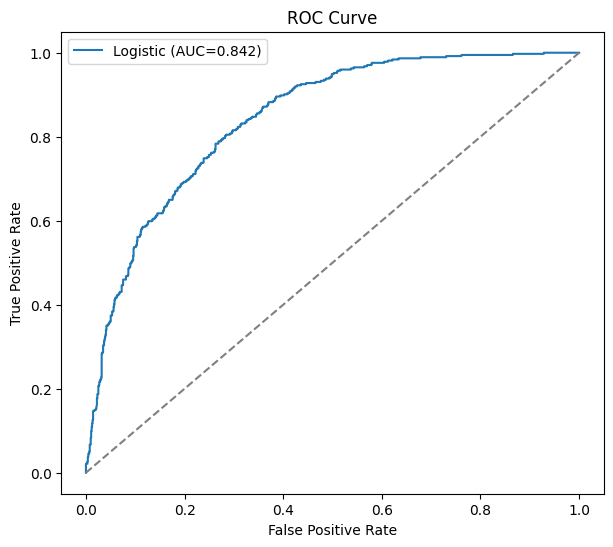

In [23]:
plt.figure(figsize=(7,6))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic (AUC={auc_lr:.3f})')

plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Random Forest

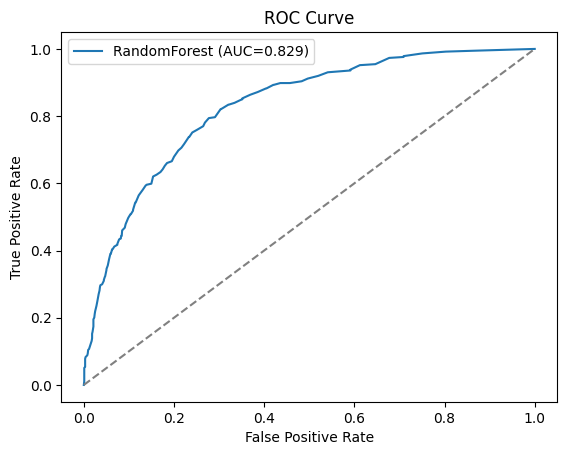

In [24]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={auc_rf:.3f})')

plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Decision Tree

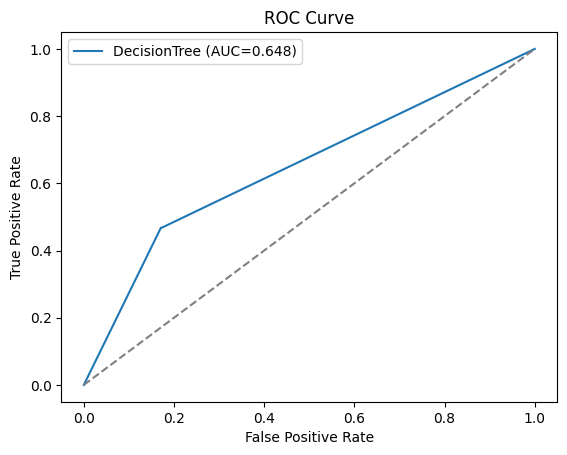

In [25]:
if y_prob_dt is not None:
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
    auc_dt = roc_auc_score(y_test, y_prob_dt)
    plt.plot(fpr_dt, tpr_dt, label=f'DecisionTree (AUC={auc_dt:.3f})')

plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 10. Precision Recall Curves Visualisations


## Logistic Regression Recall Curves

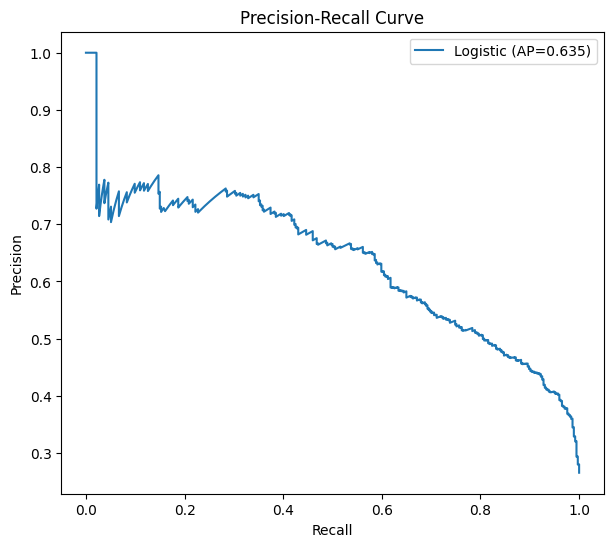

In [26]:
plt.figure(figsize=(7,6))
prec_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
ap_lr = average_precision_score(y_test, y_prob_lr)
plt.plot(recall_lr, prec_lr, label=f'Logistic (AP={ap_lr:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## Random Forest Recall Curves

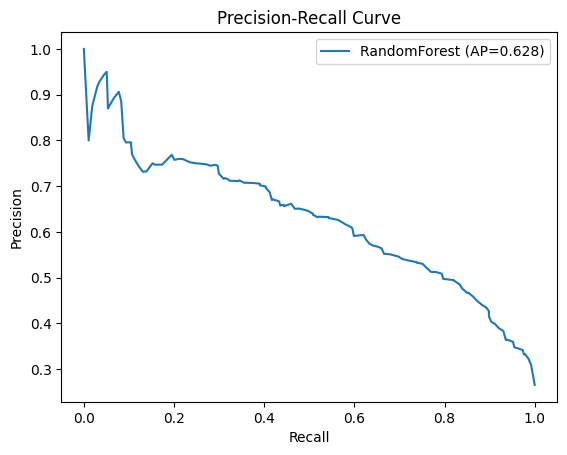

In [27]:
prec_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
ap_rf = average_precision_score(y_test, y_prob_rf)
plt.plot(recall_rf, prec_rf, label=f'RandomForest (AP={ap_rf:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## Decision Tree Recall Curves

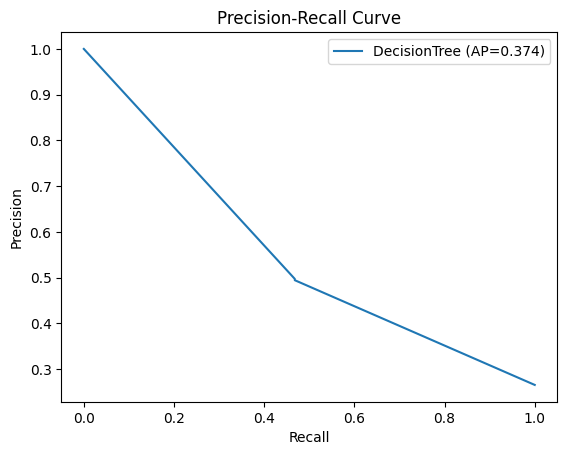

In [28]:
if y_prob_dt is not None:
    prec_dt, recall_dt, _ = precision_recall_curve(y_test, y_prob_dt)
    ap_dt = average_precision_score(y_test, y_prob_dt)
    plt.plot(recall_dt, prec_dt, label=f'DecisionTree (AP={ap_dt:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 11. Feature importance and coefficients

## Random Forest Importances

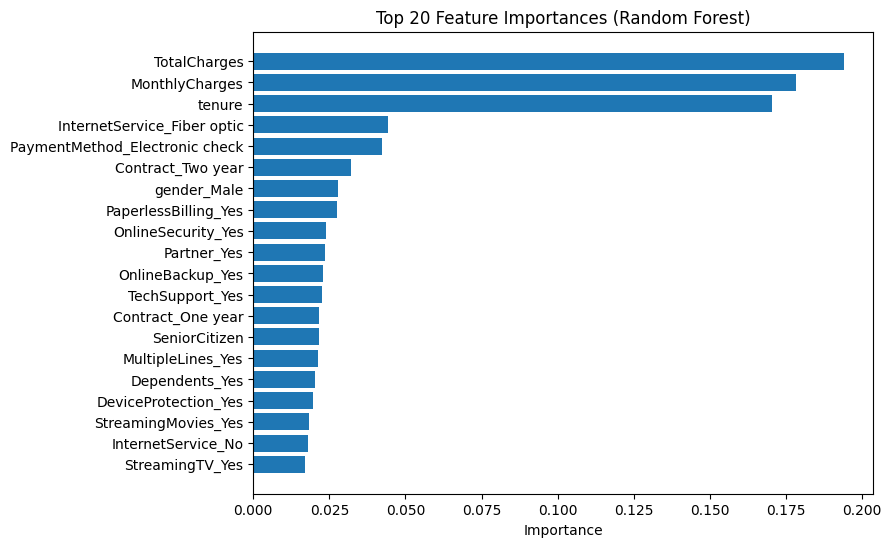

In [29]:
feature_names = X.columns.tolist()

rf_importances = rf.feature_importances_
indices = np.argsort(rf_importances)[::-1][:20]
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(8,6))
plt.barh(top_features[::-1], rf_importances[indices[::-1]])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

## Logistic Regression coefficients

In [30]:
coef = lr.coef_[0]
sorted_idx = np.argsort(coef)

print("Top 10 negative coefficients (push to class 0 - not churn):")
for i in sorted_idx[:10]:
    print(f"{feature_names[i]}: {coef[i]:.4f}")

Top 10 negative coefficients (push to class 0 - not churn):
Contract_Two year: -1.3268
tenure: -1.2523
InternetService_No: -1.0510
Contract_One year: -0.6882
OnlineSecurity_Yes: -0.3733
PhoneService_Yes: -0.3625
TechSupport_Yes: -0.3243
MonthlyCharges: -0.3020
Dependents_Yes: -0.2250
OnlineBackup_Yes: -0.1243


In [31]:
print("\nTop 10 positive coefficients (push to class 1 - churn):")
for i in sorted_idx[-10:][::-1]:
    print(f"{feature_names[i]}: {coef[i]:.4f}")


Top 10 positive coefficients (push to class 1 - churn):
InternetService_Fiber optic: 1.0484
TotalCharges: 0.5212
PaymentMethod_Electronic check: 0.3839
PaperlessBilling_Yes: 0.3736
MultipleLines_Yes: 0.3356
StreamingTV_Yes: 0.3218
StreamingMovies_Yes: 0.3214
PaymentMethod_Mailed check: 0.0697
SeniorCitizen: 0.0544
gender_Male: 0.0216


# 12. Final Comparison Table

In [ ]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
preds = [y_pred_lr, y_pred_dt, y_pred_rf]
rows = []
for name, pred in zip(models, preds):
    rows.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1': f1_score(y_test, pred)
    })
comp_df = pd.DataFrame(rows).set_index('Model').round(4)
comp_df